# Step 1: Installation and Setup

Import Section

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import multiprocessing
%matplotlib inline

# Required to initialize NN
from keras.models import Sequential
# Required to build layers of ANN and autoencoder

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense

# Required for visualization
import missingno as msno
import matplotlib.cm as cm
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt

# Required for displaying learning_curve
from sklearn.model_selection import learning_curve

from datetime import datetime
start_real = datetime.now()

In [ ]:
# Mount google drive to load Test and Train dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Retrieving train and test Mercari dataset records for processing
price_train = pd.read_csv("/content/drive/My Drive/Project/Data/ANN/Mercari_train.csv", encoding='utf-8-sig')
price_test = pd.read_csv("/content/drive/My Drive/Project/Data/ANN/Mercari_test.csv", encoding='utf-8-sig')

In [ ]:
# Displaying the dimensions of the dataset (rows, column)
print(price_train.shape)
print(price_test.shape)

(706000, 10)
(342575, 10)


**Note: please comment below code to run the model on entire datasetset**

In [ ]:
price_train=price_train[:85000]
price_test=price_test[:25000]

In [ ]:
#checking content and format of the Mercari train dataset
price_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   train_id              85000 non-null  int64  
 1   name                  85000 non-null  object 
 2   item_condition_id     85000 non-null  int64  
 3   category_name         84630 non-null  object 
 4   brand_name            48518 non-null  object 
 5   price                 85000 non-null  float64
 6   shipping              85000 non-null  int64  
 7   item_description      85000 non-null  object 
 8   date_first_available  85000 non-null  object 
 9   sell_date             85000 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 6.5+ MB


In [ ]:
#checking content and format of the Mercari test dataset
price_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   test_id               25000 non-null  int64  
 1   name                  25000 non-null  object 
 2   item_condition_id     25000 non-null  int64  
 3   category_name         24892 non-null  object 
 4   brand_name            14293 non-null  object 
 5   price                 25000 non-null  float64
 6   shipping              25000 non-null  int64  
 7   item_description      25000 non-null  object 
 8   date_first_available  25000 non-null  object 
 9   sell_date             25000 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.9+ MB


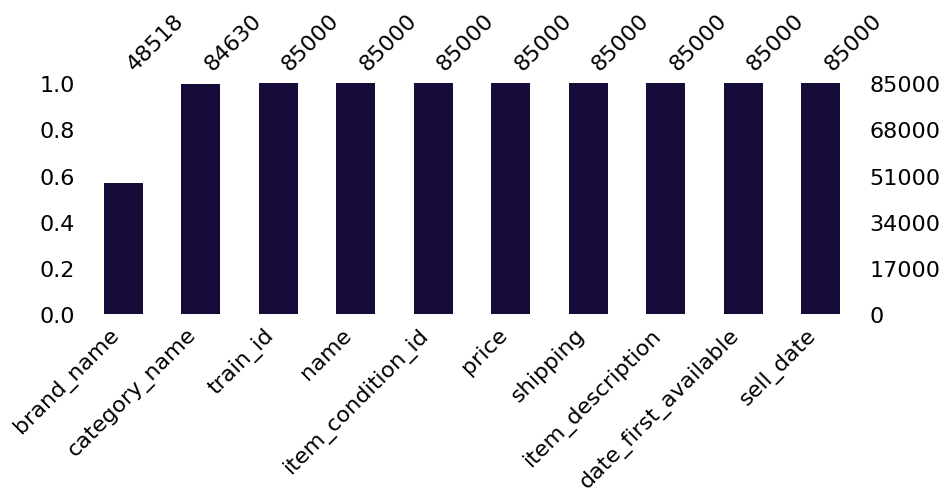

In [ ]:
#Checking for missing values in the train dataset
# Creating a colormap using 'inferno' colors
cmap = plt.get_cmap('inferno')

# Generate the missing data visualization with custom colors
msno.bar(price_train, sort='ascending', figsize=(10, 3), color=cmap(0.10))

# Display the plot
plt.show()

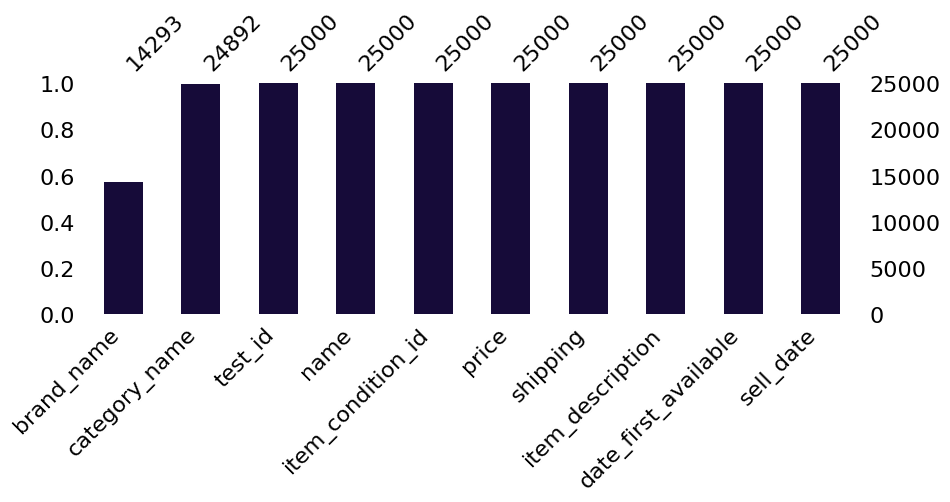

In [ ]:
# Checking for missing values in the test dataset
# Creating colormap using 'inferno' colors
cmap = plt.get_cmap('inferno')

# Generate the missing dataset visualization with custom colors
msno.bar(price_test, sort='ascending', figsize=(10, 3), color=cmap(0.10))

# Display the plot
plt.show()

# Step 2: Pre-processing of the dataset

In [ ]:
#removing unwanted columns
price_train=price_train.drop('date_first_available', axis=1)
price_train=price_train.drop('sell_date', axis=1)
price_test=price_test.drop('date_first_available', axis=1)
price_test=price_test.drop('sell_date', axis=1)

In [ ]:
# Removing outlier with price more than 200
price_train['outliers'] = price_train['price'].map(lambda x: 1 if x >200 else 0)
price_train = price_train[price_train['outliers'] ==0]
del price_train['outliers']

In [ ]:
#Getting the length of item description
price_train['length'] = price_train['item_description'].apply(lambda x: len(str(x)))
price_test['length'] = price_test['item_description'].apply(lambda x: len(str(x)))

In [ ]:
#Merging test and train dataset for further preprocessing of the textual features
dataset = pd.concat([price_train,price_test])
#Defining a variable to spliot
dataset['train_or_not'] = dataset['train_id'].map(lambda x: 1 if x.is_integer() else 0)

In [ ]:
#lowering letters
dataset['brand_name'] = dataset['brand_name'].map(lambda x: str(x).lower())
dataset['category_name'] = dataset['category_name'].map(lambda x: str(x).lower())
dataset['item_description'] = dataset['item_description'].map(lambda x: str(x).lower())
dataset['name'] = dataset['name'].map(lambda x: str(x).lower())

In [ ]:
dataset['len_description'] = dataset['item_description'].map(lambda x: len(str(x).split()))

In [ ]:
#Nan values in brand
dataset['brand_nan'] = dataset['brand_name'].map(lambda x: 1 if x =="nan" else 0)

In [ ]:
#Number of unique brand names
print(len(set(dataset['brand_name'])))
print('brand_name in train',len(set(price_train['brand_name'])))
print('brand_name in test',len(set(price_test['brand_name'])))

2111
brand_name in train 1923
brand_name in test 1157


In [ ]:
#checking the duplicate 'brand_name' records comparing with test and train dataset
train_categories= list(set(price_train['brand_name']))
test_categories= list(set(price_test['brand_name']))

in_test_not_in_train = [x for x in test_categories if x not in train_categories]
print(len(in_test_not_in_train))

in_train_not_in_test = [x for x in train_categories if x not in test_categories]
print(len(in_train_not_in_test))

188
954


In [ ]:
#category to make it easier to work with the individual categories for analysis
dataset['categories'] = dataset['category_name'].map(lambda x: list(str(x).split('/')))

In [ ]:
# Items with no descriptions
dataset['no_description'] = dataset['item_description'].map(lambda x: 1 if str(x) =='no description yet' else 0)
print(len(dataset[dataset['no_description']==1]))

6234


In [ ]:
print('Blank brand_name column & no description',len(dataset[(dataset['brand_name']=='nan') & (dataset['no_description'] ==1)]))

Blank brand_name column & no description 2769


In [ ]:
#No brand name and no desc
no_desc_no_brand = dataset[(dataset['brand_name']=='nan') & (dataset['no_description'] ==1)]
no_desc_no_brand['test'] = no_desc_no_brand['test_id'].apply(lambda x: 1 if x.is_integer() else 0)
no_desc_no_brand = no_desc_no_brand[no_desc_no_brand['test'] ==0]

<ipython-input-22-af9a6c71b580>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_desc_no_brand['test'] = no_desc_no_brand['test_id'].apply(lambda x: 1 if x.is_integer() else 0)


In [ ]:
#No of rows whose price is bigger than 200
print("No of rows whose price is bigger than 200 in above category",len(no_desc_no_brand[no_desc_no_brand['price'] >200]))

no_desc_no_brand['price'].describe()
del no_desc_no_brand

No of rows whose price is bigger than 200 in above category 0


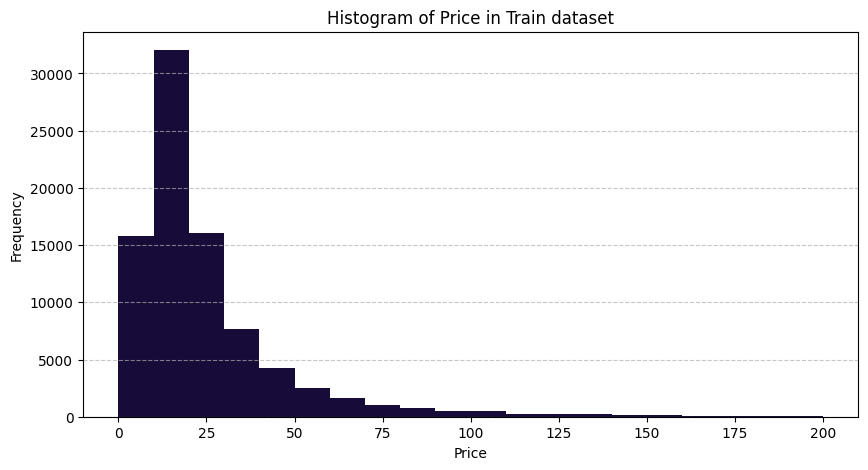

In [ ]:
cmap = plt.get_cmap('inferno')

# Filter the 'price' column in the 'train' dataset
filtered_prices = price_train[price_train['price'] < 200]['price']

# Create a histogram using Matplotlib with navy blue bars
plt.figure(figsize=(10, 5))
plt.hist(filtered_prices, bins=range(0, 201, 10), color=cmap(0.10))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price in Train dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
dataset['price'].describe().apply(lambda x: format(x, 'f'))

count    109422.000000
mean         25.113789
std          28.558403
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        1500.000000
Name: price, dtype: object

In [ ]:
#Length of categories
dataset['len_categories'] = dataset['categories'].map(lambda x: len(x))

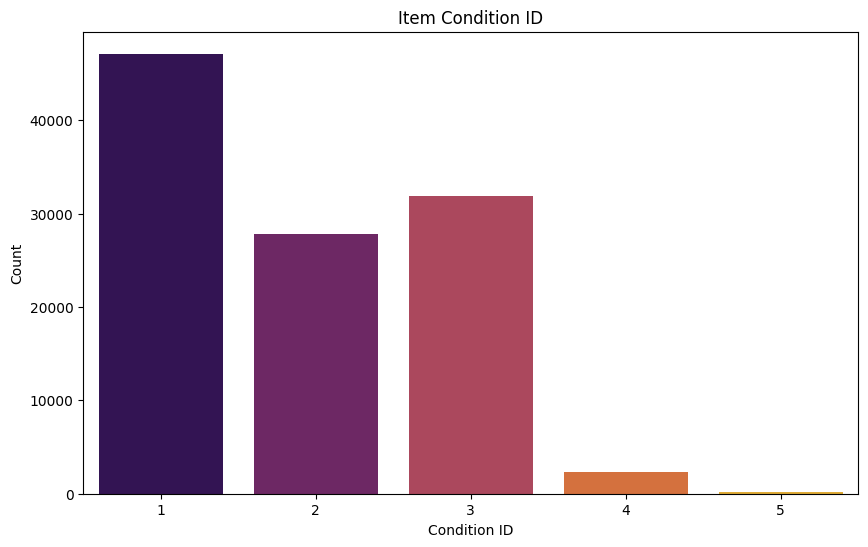

In [ ]:
# Value counts for item_condition_id
item_condition = dataset['item_condition_id'].value_counts()[:5].to_frame().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='item_condition_id', data=item_condition, palette='inferno')
plt.title('Item Condition ID')
plt.xlabel('Condition ID')
plt.ylabel('Count')
plt.show()

In [ ]:
#Making binary 'item_condition_id' feature column
ic_list = list(set(dataset['item_condition_id']))

for i in ic_list:
    dataset['item_condition_id'+str(i)] = dataset['item_condition_id'].map(lambda x: 1 if x==i else 0)

del dataset['item_condition_id']

<Axes: >

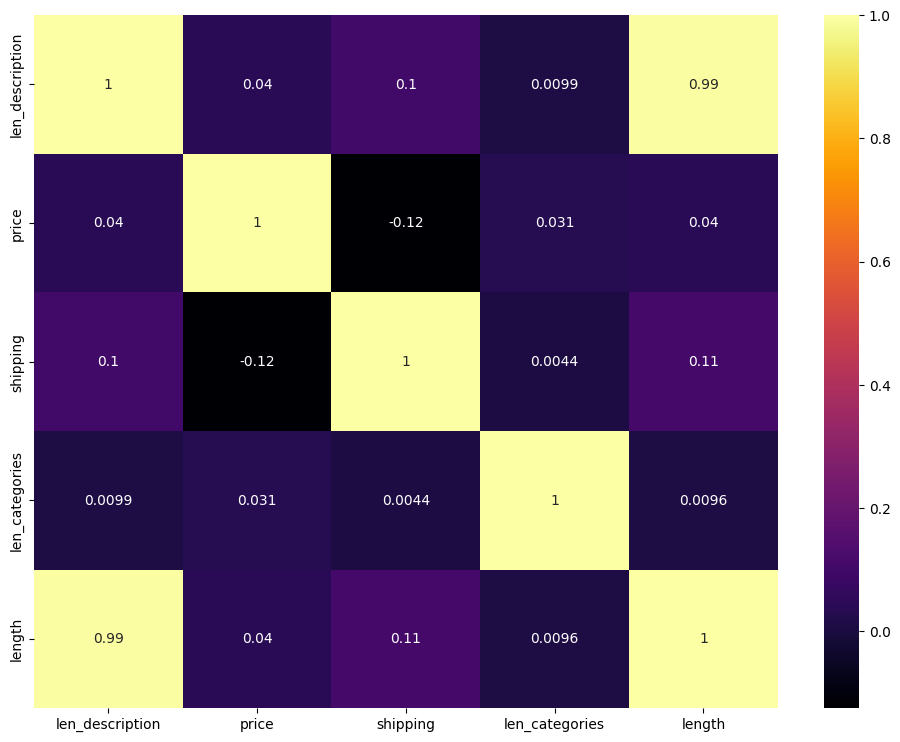

In [ ]:
#Correlation between len_description and price, shipping, len_categories, length, feature records
corr = dataset[['len_description','price','shipping','len_categories','length']].corr()

# Set up the matplot figure
f,ax = plt.subplots(figsize=(12,9))

#Draw the heatmap using seaborn
sns.heatmap(corr, cmap='inferno', annot=True)

In [ ]:
#Determined important features based on above correlation matrix
most_imp = ['cat3_full-length', 'cat2_jewelry', 'cat3_tracksuits & sweats', 'item_description_case', 'name_michael', 'name_ring', 'name_nike', 'item_description_price', 'name_pink', 'cat3_headphones', 'len_description', 'item_description_[rm]', 'cat1_electronics', 'cat3_sticker', 'length', 'item_description_silver', 'cat3_consoles', 'item_condition_id5', 'item_description_-', 'brand_old navy', 'item_condition_id4', 'brand_forever 21', 'name_palette', 'cat2_cat2_other', 'name_bracelet', 'item_description_set', 'cat3_hoodie', 'name_boys', 'cat3_makeup palettes', 'name_purse', 'name_bundle', 'brand_lululemon', 'cat2_makeup', 'brand_beats', 'cat1_home', 'item_description_high', 'cat2_home appliances', 'item_description_full', 'cat2_dresses', 'brand_apple', 'brand_ugg australia', 'cat1_beauty', 'name_sleeve', 'brand_kate spade', 'brand_gymshark', "cat2_women's accessories", 'cat2_diapering', 'item_description_bag', 'name_air', 'name_eagle', "cat2_men's accessories", 'name_one', 'brand_lularoe', 'cat3_socks', 'name_jacket', 'name_coach', 'item_description_super', 'name_jordan', "brand_victoria's secret", 'brand_air jordan', 'cat1_women', 'item_description_fits', 'name_lace', 'item_description_new', 'name_top', 'brand_louis vuitton', 'brand_chanel', 'cat3_shoes', 'cat2_bags and purses', 'item_description_shipping', 'cat2_underwear', 'item_condition_id1', 'name_lularoe', 'item_description_comes', 'item_description_item', 'item_description_bundle', 'brand_samsung', 'name_disney', 'cat1_handmade', 'brand_supreme', 'brand_lilly pulitzer', 'item_description_see', 'shipping', 'name_case', 'cat2_cell phones & accessories', 'name_funko', 'name_silver', 'item_description_firm', 'cat3_shipping supplies', 'brand_tiffany & co.', 'item_description_8', 'brand_michael kors', 'brand_tory burch', 'cat2_sweaters', 'brand_kendra scott', 'name_vs', 'name_adidas', 'name_reserved', 'cat3_backpack style', 'brand_adidas', 'item_description_secret', 'item_condition_id2', 'item_description_ship', 'item_description_red', 'cat2_coats & jackets', 'cat3_hair styling tools', 'cat3_fleece jacket', 'cat2_shoes', 'item_description_free', 'name_shorts', 'brand_american eagle', 'len_categories', 'name_kors', 'brand_senegence', 'name_girls', 'item_description_x', 'name_makeup', 'name_shirt', 'item_description_box', 'item_description_body', 'cat3_pants, tights, leggings', 'name_set', 'item_description_gold', 'item_description_condition', 'brand_puma', 'brand_birkenstock', 'name_lot', 'item_description_cute', 'cat2_trading cards', 'cat1_men', 'item_description_7', 'item_description_beautiful', 'brand_miss me', 'name_gold', "cat2_women's handbags", 'cat3_necklaces', 'brand_other_brand', 'cat3_dining & entertaining', 'cat2_tops & blouses', 'brand_dooney & bourke', 'item_description_save', 'item_condition_id3', 'brand_rae dunn', 'brand_pink', 'item_description_plus', 'cat3_jerseys', 'cat3_cosmetic bags', 'cat3_flats', 'cat3_athletic', 'brand_beats by dr. dre', 'brand_nan', 'cat1_kids', 'brand_free people', 'cat2_computers & tablets', 'cat3_cases, covers & skins', 'cat2_cameras & photography', 'cat3_boots', 'item_description_original']
print(len(most_imp))

158


In [ ]:
itemdesc_imp = [x[17:] for x in most_imp if 'item_description_' in x]
name_imp = [x[5:] for x in most_imp if 'name_' in x]
brand_imp = [x[6:] for x in most_imp if 'brand_' in x]
cat1_imp= [x[5:] for x in most_imp if 'cat1_' in x]
cat2_imp= [x[5:] for x in most_imp if 'cat2_' in x]
cat3_imp= [x[5:] for x in most_imp if 'cat3_' in x]
other_imp = ['len_description', 'length', 'item_condition_id5', 'item_condition_id4', 'item_condition_id1', 'shipping', 'item_condition_id2', 'len_categories', 'item_condition_id3']

In [ ]:
# New Pre-processed feature dataset based on correlation
# presented with relation to the main feature column and length associated with it
print("Length of new features related to each parent feature" )
print("Length of name: ",len(name_imp))
print("Length of item description: ",len(itemdesc_imp))
print("Length of brand: ",len(brand_imp))
print("Length of category_1: ",len(cat1_imp))
print("Length of category_2: ",len(cat2_imp))
print("Length of cat egory_3: ",len(cat3_imp))
print("Length of other important features: ",len(other_imp))
print("Total length of pre-processed features: ", len(most_imp))

Length of new features related to each parent feature
Length of name:  34
Length of item description:  34
Length of brand:  33
Length of category_1:  7
Length of category_2:  19
Length of cat egory_3:  22
Length of other important features:  9
Total length of pre-processed features:  158


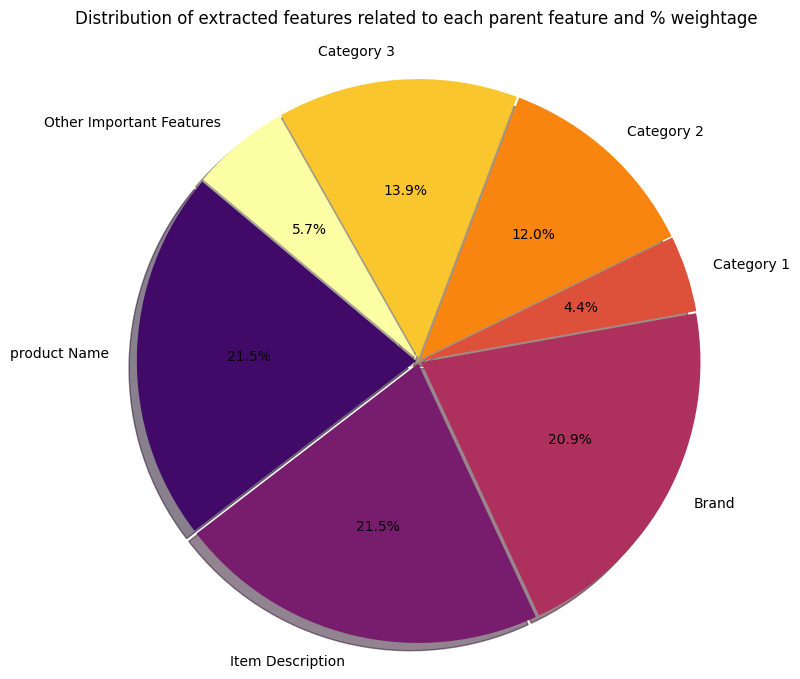

In [ ]:
new_features = ['product Name', 'Item Description', 'Brand', 'Category 1', 'Category 2', 'Category 3', 'Other Important Features', ]
new_featurelengths = [len(name_imp), len(itemdesc_imp), len(brand_imp), len(cat1_imp), len(cat2_imp), len(cat3_imp), len(other_imp)]

#creating a pie chart representation
colors = cm.inferno(np.linspace(0.2, 1, len(new_features)))
plt.figure(figsize=(8, 8))
plt.pie(new_featurelengths, labels=new_features, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True, explode=np.linspace(0.01,0.01, len(new_features)))
plt.title('Distribution of extracted features related to each parent feature and % weightage \n')
plt.axis('equal')
plt.show()

In [ ]:
#Creating columns for parent "name" column
for i in name_imp:
    dataset['name_'+str(i)] = dataset['name'].map(lambda x: 1 if i in x else 0)

print("preprocessing on name feature completed")

preprocessing on name feature completed


In [ ]:
#Creating columns for parent "item_description_" column
for i in itemdesc_imp:
    dataset['item_description_'+str(i)] = dataset['item_description'].map(lambda x: 1 if i in x else 0)
print("preprocessing on description feature completed")

preprocessing on description feature completed


In [ ]:
#Creating columns for parent "brands" column
most_common_brands = brand_imp
#If a brand not in common brands, it was labeled as other_brand
other_brand = "other_brand"
dataset['brand_name'] = dataset['brand_name'].map(lambda x: x if x in most_common_brands else other_brand)

In [ ]:
# Creating dummnies for brand_name column
empty_df = pd.get_dummies(dataset['brand_name'])
impFeature_list = list(empty_df.columns.values)
impFeature_list = ['brand_'+str(x) for x in impFeature_list]
empty_df.columns = impFeature_list
print(impFeature_list)

['brand_adidas', 'brand_air jordan', 'brand_american eagle', 'brand_apple', 'brand_beats', 'brand_beats by dr. dre', 'brand_birkenstock', 'brand_chanel', 'brand_dooney & bourke', 'brand_forever 21', 'brand_free people', 'brand_gymshark', 'brand_kate spade', 'brand_kendra scott', 'brand_lilly pulitzer', 'brand_louis vuitton', 'brand_lularoe', 'brand_lululemon', 'brand_michael kors', 'brand_miss me', 'brand_nan', 'brand_old navy', 'brand_other_brand', 'brand_pink', 'brand_puma', 'brand_rae dunn', 'brand_samsung', 'brand_senegence', 'brand_supreme', 'brand_tiffany & co.', 'brand_tory burch', 'brand_ugg australia', "brand_victoria's secret"]


In [ ]:
dataset2 = pd.concat([dataset,empty_df],axis=1)
dataset = dataset2
del dataset2,empty_df
print("preprocessing on brand feature completed")

preprocessing on brand feature completed


In [ ]:
print(list(dataset.columns.values))
print(len(list(dataset.columns.values)))

['train_id', 'name', 'category_name', 'brand_name', 'price', 'shipping', 'item_description', 'length', 'test_id', 'train_or_not', 'len_description', 'brand_nan', 'categories', 'no_description', 'len_categories', 'item_condition_id1', 'item_condition_id2', 'item_condition_id3', 'item_condition_id4', 'item_condition_id5', 'name_michael', 'name_ring', 'name_nike', 'name_pink', 'name_palette', 'name_bracelet', 'name_boys', 'name_purse', 'name_bundle', 'name_sleeve', 'name_air', 'name_eagle', 'name_one', 'name_jacket', 'name_coach', 'name_jordan', 'name_lace', 'name_top', 'name_lularoe', 'name_disney', 'name_case', 'name_funko', 'name_silver', 'name_vs', 'name_adidas', 'name_reserved', 'name_shorts', 'name_kors', 'name_girls', 'name_makeup', 'name_shirt', 'name_set', 'name_lot', 'name_gold', 'item_description_case', 'item_description_price', 'item_description_[rm]', 'item_description_silver', 'item_description_-', 'item_description_set', 'item_description_high', 'item_description_full', 'it

In [ ]:
#Creating separate  olumns for each categories
dataset['categories']= dataset['categories'].map(lambda x: list(x)+[0,0,0,0])
dataset['cat1']=dataset['categories'].map(lambda x: x[0])
dataset['cat2']=dataset['categories'].map(lambda x: x[1])
dataset['cat3']=dataset['categories'].map(lambda x: x[2])
dataset['cat4']=dataset['categories'].map(lambda x: x[3])
dataset['cat5']=dataset['categories'].map(lambda x: x[4])

most_common_cat1=dataset['cat1'].value_counts().sort_values(ascending=False)[:11]
most_common_cat2=dataset['cat2'].value_counts().sort_values(ascending=False)[:70]
most_common_cat3=dataset['cat3'].value_counts().sort_values(ascending=False)[:90]
most_common_cat4=dataset['cat4'].value_counts().sort_values(ascending=False)[:100]
most_common_cat5=dataset['cat5'].value_counts().sort_values(ascending=False)[:100]

In [ ]:
#Bucketing features for Category 1
cat1_b1 = ['women','vintage & collectibles','sports & outdoors','nan','home']
cat1_b2 = ['other','beauty','handmade']
cat1_b3 = ['men','electronics','beauty']
dataset['cat1_fe'] = dataset['cat1'].map(lambda x: 1 if x in cat1_b1 else 2 if x in cat1_b2 else 3)

In [ ]:
#Bucketing features for Category 4
dataset['cat4_tablet'] = dataset['cat4'].map(lambda x: 1 if x =='tablet' else 0)

In [ ]:
#Bucketing features for Category 5
ebook = ['ebook access','ebook readers']
dataset['cat5_ebook'] = dataset['cat5'].map(lambda x: 1 if x in ebook else 0)

In [ ]:
#Considering the top 3 categories
most_common_cat1=cat1_imp
most_common_cat2=cat2_imp
most_common_cat3=cat3_imp
cat1_list = list(most_common_cat1)
cat2_list = list(most_common_cat2)
cat3_list = list(most_common_cat3)

In [ ]:
#If a category not in cat1, it was labeled as 'cat1_other'
cat1_other = "cat1_other"
dataset['cat1'] = dataset['cat1'].map(lambda x: x if x in cat1_list else cat1_other)
#If a category not in cat2, it was labeled as 'cat2_other'
cat2_other = "cat2_other"
dataset['cat2'] = dataset['cat2'].map(lambda x: x if x in cat2_list else cat2_other)
#If a category not in cat3, it was labeled as 'cat3_other'
cat3_other = "cat3_other"
dataset['cat3'] = dataset['cat3'].map(lambda x: x if x in cat3_list else cat3_other)

In [ ]:
cat1_exp = ['electronics']
dataset['cat1_exp'] = dataset['cat1'].map(lambda x: 1 if x in cat1_exp else 0)

cat2_exp = ["women's handbags","cell phones & accessories","shoes"]
dataset['cat2_exp'] = dataset['cat2'].map(lambda x: 1 if x in cat2_exp else 0)

cat3_exp = ["cell phones & smartphones","shoulder bag","athletic","totes & shoppers","messenger & crossbody"]
dataset['cat3_exp'] = dataset['cat3'].map(lambda x: 1 if x in cat3_exp else 0)


In [ ]:
good_brands = ['forever 21', 'american eagle', 'under armour', 'old navy', 'hollister', "carter's", 'brandy melville', 'gap', 'charlotte russe', 'ralph lauren', 'converse', 'h&m', 'express', 'abercrombie & fitch', 'nyx', 'hot topic', 'calvin klein', "levi's®", 'anastasia beverly hills', 'torrid', 'tommy hilfiger', 'mossimo', 'aeropostale', 'columbia', 'guess', 'urban outfitters', 'target', 'xhilaration', 'maybelline', 'american apparel', 'maurices', 'elmers', 'rue21', "l'oreal", 'smashbox', 'champion', 'fashion nova', 'lucky brand', 'wet n wild', 'banana republic', 'toms', 'popsockets', 'wet seal', 'ann taylor loft', 'colourpop cosmetics', 'hello kitty', 'it cosmetics', 'merona', "osh kosh b'gosh", 'crocs', 'rue', 'e.l.f.', 'avon', 'revlon', "the children's place", 'starbucks', 'stila', 'jessica simpson', 'new york & company', 'lane bryant', 'pacific sunwear', 'skechers', 'motherhood maternity', 'nine west', "children's place", 'no boundaries', 'simply southern', 'athleta', 'roxy', 'fox racing', 'covergirl', 'bareminerals', 'aldo', 'gildan', 'new era', 'bare escentuals', 'silver jeans co.', 'yankee candle', 'bullhead', 'lacoste', 'lc lauren conrad', 'faded glory', 'hollister co.', 'hot wheels', 'billabong', 'laura mercier', 'tupperware', 'white house black market', 'affliction', 'stride rite', 'mac cosmetic', 'crest', 'sally hansen', 'nickelodeon', 'cacique', 'aéropostale', 'bobbi brown', "candie's", 'gillette', 'tobi', 'volcom', 'sperrys', 'mudd', 'gerber', 'leap frog', 'diamond supply co.', 'cato', 'nautica', 'laura geller', 'my little pony', 'disney princess', 'danskin', 'cherokee', 'mossimo supply co.', 'lime crime', 'vtech', 'sperry', 'dc shoes', 'daytrip', 'kenneth cole new york', 'dickies', 'stussy', 'pampered chef', 'cotton on', 'the limited', 'neutrogena', 'inc international concepts', 'ardell', 'hanna anderson', 'liz lange', 'so', 'comfort colors', 'liz claiborne', 'hurley', 'eddie bauer', 'bcbgeneration', "burt's bees", 'ann taylor', "chico's", "dr. brown's", 'nerf', 'thebalm', 'garnier', 'papaya', 'aden & anais', 'bongo', 'melissa & doug', 'fila', 'dove', 'make up for ever', 'american rag', 'ed hardy', 'sonoma', 'beautyblender®', 'aerie', 'petsmart', 'huggies', 'sesame street', 'ikea', 'anne klein', 'febreze', 'origins', 'pier one', 'worthington', 'munchkin', 'ivory ella', 'floam', 'bonne bell', 'ambiance apparel', 'avent', 'converse shoes', 'full tilt', 'dkny', 'vanity', 'shiseido', 'wrangler', 'lokai', 'arizona', 'the body shop', 'spanx', 'apt.', 'jumping beans', 'hourglass cosmetics', 'hard candy', 'a.n.a', 'obey', 'sperry top-sider', 'boppy', 'schick', 'rock & republic', 'simply vera vera wang', 'ben nye', 'almay', 'thrasher magazine', "lands' end", 'jennifer lopez', 'infantino', 'bke', "o'neill", 'rimmel', 'chaps', 'disney pixar cars', 'croft & barrow', 'op', "gilligan & o'malley", 'colgate', 'bdg', 'eos', 'rvca', 'pampers', 'dermablend', 'wilton', 'delia*s', 'modcloth', 'fabletics', 'ymi', 'venus', 'la hearts', 'dressbarn', 'disney pixar', "kiehl's", 'style&co.', 'soffe', 'playtex', 'tommee tippee', 'xoxo', 'vigoss', 'speedo', 'hanes', 'rave', 'paper mate', 'tommy bahama', 'sinful by affliction', 'derek heart', 'refuge', 'sanuk', 'talbots', 'elizabeth arden', 'olay', 'zella', 'lalaloopsy', 'avenue', 'pokemon usa', 'pampers swaddlers', "francesca's collections", 'gilly hicks', 'kendall & kylie', 'zumba', 'la idol', 'bumbo', 'arizona jean company', 'decree', 'huggies snug & dry', 'glade', 'dreamworks', 'franco sarto', "st. john's bay", 'nivea', 'chinese laundry', 'incipio', 'us polo assn', "claire's", 'boohoo', "lulu's", 'kotex', 'cabi', 'obey clothing', 'jones new york', 'crayola', 'disney jr.', 'everlast', 'lee', 'material girl', 'catalina', 'art', 'levi strauss & co.', 'bic', 'nick jr.', 'l.e.i.', "tilly's", 'dockers', 'russell athletic', 'capezio', 'kiplling', 'avia', 'charming charlie', 'air wick', 'nike golf', 'kimchi blue', 'hydraulic', 'dollhouse', 'geneva', 'justfab', 'kardashian kollection', 'pur minerals', 'nollie', 'lucy activewear', 'partylite', 'bobbie brooks', 'the hundreds', "dr. scholl's", 'hamilton beach', 'young & reckless', 'always', 'life is good', 'reef', 'southern marsh', 'brooks brothers', 'unionbay', 'izod', 'elle', 'fila sport', 'playskool', 'lenox', 'aerosoles', 'coty', 'baby phat', 'danskin now', 'moda international', 'bravado', 'sharpie', 'george', 'kodak', 'loft', 'belkin', 'apt. 9', 'red cherry', 'huf', 'a pea in the pod', 'john deere', 'new directions', 'robeez', 'twenty one', 'premier designs', 'ivanka trump', 'accessory workshop', 'ecko unltd.', 'safety st', 'max studio', 'hot kiss', 'jj cole collections', 'baby einstein', 'madden girl', 'tek gear', 'cynthia rowley', 'xersion', 'nostalgia electrics', 'bisou bisou', 'mam baby', 'huggies little snugglers', 'thrasher', 'arden b', 'angie', "summer's eve", 'nuk', 'quiksilver', 'precious moments', 'neff', 'degree', 'luvs', 'keds', 'maidenform', 'm.i.a.', 'pillow pets', 'celebrity pink', 'tahari', 'bass', "a'gaci", 'a. byer', 'one clothing', 'carbon', 'corningware', 'bright starts', 'scott paper', 'daisy fuentes', 'nhl', 'kut from the kloth', 'jaclyn smith', 'white stag', 'bandolino', 'cartoon network', 'silver jeans', 'missguided', 'fashion bug', 'jakks pacific', 'antonio melani', 'stance', 'rainbow shops', 'stüssy', 'qupid', 'belly bandit®', 'brita', 'browning', 'aveeno', 'lrg', "cabela's", 'oster', '% pure', 'huggies pull-ups', 'silence + noise', 'liz lange for target', 'ashley stewart', 'monopoly', 'k-swiss', 'willow', 'nascar', 'southpole', 'nicole miller', 'manic panic', 'mally beauty', 'homedics', 'charter club', 'minnetonka', 'angels', 'okie dokie', 'tonka', '47 brand', 'nuby', 'dress barn', 'gloria vanderbilt', 'love culture', 'aroma', 'rewind', 'realtree', 'machine', 'top paw', 'rampage', 'on the byas', 'rocawear', 'crooks & castles', 'ferasali', 'eyeshadow', 'coldwater creek', 'hasbro games', 'divided', 'jada toys', 'jockey', 'kenneth cole reaction', 'body central', 'body glove', 'jerzees', 'empire', 'fruit of the loom', 'guy harvey', 'bebop', 'my michelle', 'axe', 'poetry', 'marmot', 'dana buchman', 'perry ellis', 'tampax', 'urban pipeline', 'jolt', 'ball', 'next level', 'kirra', 'deb', 'soda', 'jansport', 'helly hansen', 'gund', 'van heusen', 'madame alexander', 'j. jill', 'thermos', 'kim rogers', 'sunbeam', 'just my size', 'speechless', 'frontline', 'wubbanub', 'the first years', 'mr. coffee', 'play-doh', 'primitive', 'anchor hocking', 'gianni bini', 'studio y', 'michael stars', 'mighty fine', 'marika', 'garage', 'self esteem', 'charlotte tilbury', 'trixxi', 'lysol', 'conair', "frederick's of hollywood", 'a plus child supply', 'flying monkey', 'city triangles', 'harajuku lovers', 'jane iredale', 'suave', 'fun world', 'g by guess', 'the sak', 'kensie', 'jamberry', 'kyodan', 'christopher & banks', 'breathablebaby', 'custom accessories', 'sean john', 'lucky brand jeans', 'enfagrow', 'romeo & juliet couture', 'farberware', 'matchbox', 'esprit', 'baby bullet', 'cowgirl tuff', 'dragon ball z', 'anvil', 'mossy oak', 'c by champion', 'nokia', 'pro keds', 'dr. seuss', 'energie', 'cottonelle', 'rubbermaid', 'boon', 'stayfree', 'lauren conrad', 'element', 'kong', 'covington', 'buffalo', 'ivivva', 'bcbg', 'sugarpill', 'huggies little movers', 'paris blues', 'tultex', 'baublebar', 'hue', 'cable & gauge', 'soma', 'vocal', 'mitchum', 'teva', 'zion rootswear', 'scotch', 'gaiam', 'tomtom', 'cello jeans', 'pilot', 'style & co', "altar'd state", 'miley cyrus', 'bcx', 'blizzard', 'venezia', 'isaac mizrahi', 'ellen tracy', 'keen', 'fox', 'rival', 'zeroxposur', 'zoo york', 'rocket dog', 'discovery kids', 'melissa', 'blue asphalt', 'furminator', 'nick & nora', 'shoe dazzle', 'vanilla star', 'as seen on tv', 'creativity for kids', 'dial', 'soprano', 'george foreman', 'en focus studio', 'mango', 'laura ashley', 'andrew christian', 'pinkblush']

In [ ]:
dataset['good_brand_or_not'] = dataset['brand_name'].map(lambda x: 1 if x in good_brands else 0)

In [ ]:
#Making binary for cat1
empty_df1 = pd.get_dummies(dataset['cat1'])
impFeature_list1 = list(empty_df1.columns.values)
impFeature_list1 = ['cat1_' + str(x) for x in impFeature_list1]
empty_df1.columns = impFeature_list1
#Making binary for cat2
empty_df2 = pd.get_dummies(dataset['cat2'])
impFeature_list2 = list(empty_df2.columns.values)
impFeature_list2 = ['cat2_' + str(x) for x in impFeature_list2]
empty_df2.columns = impFeature_list2
#Making binary for cat3
empty_df3 = pd.get_dummies(dataset['cat3'])
impFeature_list3 = list(empty_df3.columns.values)
impFeature_list3 = ['cat3_' + str(x) for x in impFeature_list3]
empty_df3.columns = impFeature_list3
#Merging them
dataset2 = pd.concat([dataset,empty_df1,empty_df2,empty_df3],axis=1)
dataset = dataset2
#Deleting unnecessary things
del dataset2,empty_df1,empty_df2,empty_df3
del dataset['cat1'],dataset['cat2'],dataset['cat3'],dataset['cat4'],dataset['cat5'],dataset['item_description'],dataset['name'],dataset['categories'],dataset['category_name'],dataset['brand_name']
print("pre-processing on category feature completed")

pre-processing on category feature completed


In [ ]:
#printing information of the final pre-processed dataFrame
print(dataset.shape)

print(dataset.info())

(109422, 173)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 109422 entries, 0 to 24999
Columns: 173 entries, train_id to cat3_tracksuits & sweats
dtypes: float64(3), int64(87), uint8(83)
memory usage: 84.6 MB
None


In [ ]:
#printing final pre-processed data and its shape
dataset

,train_id,price,shipping,length,test_id,train_or_not,len_description,brand_nan,no_description,len_categories,...,cat3_hoodie,cat3_jerseys,cat3_makeup palettes,cat3_necklaces,"cat3_pants, tights, leggings",cat3_shipping supplies,cat3_shoes,cat3_socks,cat3_sticker,cat3_tracksuits & sweats
0,0.0,10.0,1,18,NaN,1,3,1,1,3,...,0,0,0,0,0,0,0,0,0,0
1,1.0,52.0,0,188,NaN,1,36,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2.0,10.0,1,124,NaN,1,29,0,0,3,...,0,0,0,0,0,0,0,0,0,0
3,3.0,35.0,1,173,NaN,1,32,1,0,3,...,0,0,0,0,0,0,0,0,0,0
4,4.0,44.0,0,41,NaN,1,5,1,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,NaN,6.0,1,71,24995.0,0,12,0,0,3,...,0,0,0,0,0,0,0,0,0,0
24996,NaN,13.0,1,74,24996.0,0,15,0,0,3,...,0,0,0,0,0,0,0,0,0,0
24997,NaN,10.0,0,196,24997.0,0,38,0,0,3,...,0,0,0,0,0,0,0,0,0,0
24998,NaN,10.0,0,198,24998.0,0,38,1,0,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#preparation of next step for building ANN model
test_id = dataset['test_id']
train_id = dataset['train_id']
del dataset['train_id'],dataset['test_id']
dataset_head = dataset.head()
#Separating the merged dataset into train and test
training = dataset[dataset['train_or_not'] ==1]
testing = dataset[dataset['train_or_not'] ==0]

In [ ]:
#deleting train and test datasetset identifiers
del training['train_or_not']
del testing['train_or_not']

In [ ]:
# getting insights of training dataset
training

,price,shipping,length,len_description,brand_nan,no_description,len_categories,item_condition_id1,item_condition_id2,item_condition_id3,...,cat3_hoodie,cat3_jerseys,cat3_makeup palettes,cat3_necklaces,"cat3_pants, tights, leggings",cat3_shipping supplies,cat3_shoes,cat3_socks,cat3_sticker,cat3_tracksuits & sweats
0,10.0,1,18,3,1,1,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,52.0,0,188,36,0,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,10.0,1,124,29,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,35.0,1,173,32,1,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44.0,0,41,5,1,0,3,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84995,16.0,0,86,16,0,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84996,23.0,0,126,25,1,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
84997,45.0,1,225,43,0,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
84998,36.0,1,247,47,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# getting insights of training dataset
testing

,price,shipping,length,len_description,brand_nan,no_description,len_categories,item_condition_id1,item_condition_id2,item_condition_id3,...,cat3_hoodie,cat3_jerseys,cat3_makeup palettes,cat3_necklaces,"cat3_pants, tights, leggings",cat3_shipping supplies,cat3_shoes,cat3_socks,cat3_sticker,cat3_tracksuits & sweats
0,14.0,0,123,21,1,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,22.0,0,86,14,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,116.0,0,337,55,1,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,35.0,1,130,23,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,55.0,0,157,25,1,0,3,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,6.0,1,71,12,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,13.0,1,74,15,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,10.0,0,196,38,0,0,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
24998,10.0,0,198,38,1,0,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_y = training['price'].values
train_y = np.log(train_y+1)
test_y = testing['price'].values
test_y = np.log(test_y+1)

#Deleting price column from train and test dataset
del training['price']
del testing['price']
train_size = len(list(training.columns.values))
train_names = list(training.columns.values)

In [ ]:
print(train_names)

['shipping', 'length', 'len_description', 'brand_nan', 'no_description', 'len_categories', 'item_condition_id1', 'item_condition_id2', 'item_condition_id3', 'item_condition_id4', 'item_condition_id5', 'name_michael', 'name_ring', 'name_nike', 'name_pink', 'name_palette', 'name_bracelet', 'name_boys', 'name_purse', 'name_bundle', 'name_sleeve', 'name_air', 'name_eagle', 'name_one', 'name_jacket', 'name_coach', 'name_jordan', 'name_lace', 'name_top', 'name_lularoe', 'name_disney', 'name_case', 'name_funko', 'name_silver', 'name_vs', 'name_adidas', 'name_reserved', 'name_shorts', 'name_kors', 'name_girls', 'name_makeup', 'name_shirt', 'name_set', 'name_lot', 'name_gold', 'item_description_case', 'item_description_price', 'item_description_[rm]', 'item_description_silver', 'item_description_-', 'item_description_set', 'item_description_high', 'item_description_full', 'item_description_bag', 'item_description_super', 'item_description_fits', 'item_description_new', 'item_description_shippin

In [ ]:
#setting identified important columns
testing.columns = train_names
training.columns = train_names

price_training = training
price_testing = testing

print("Shape of new dataset")
print("Training dataset",(price_training.shape))
print("Testing dataset",(price_testing.shape))


Shape of new dataset
Training dataset (84422, 169)
Testing dataset (25000, 169)


In [ ]:
# calculating the input nodes for autoencoder algorithm
input_node = len(list(price_training.columns.values))
print("there are ",input_node," nodes in input layer")

there are  169  nodes in input layer


# Step 3: Feature reduction

In [ ]:
# Preparation of data for feature reduction
price_training = price_training.values
price_testing = price_testing.values

sc_X = StandardScaler()
price_training = sc_X.fit_transform(price_training)
price_testing = sc_X.transform(price_testing)

In [ ]:
# Defining early stopping- a regularization technique
# Below mentioned code for callback will stop the training when there is no improvement in
# the loss for two consecutive epochs.

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Build an autoencoder for feature reduction #

# Below code defines variable for number of input and reduced feature set neurons
input_dim = price_training.shape[1]
encoding_dim = 128  # Number of neurons in the encoded layer

# Define an autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='relu')(encoded)

autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train an autoencoder
history= autoencoder.fit(price_training, price_training, epochs=50, batch_size=32, shuffle=True, validation_data=(price_testing, price_testing), callbacks=callback)

# Using trained autoencoder extract reduced feature set
reducedFeatures= keras.Model(inputs=input_layer, outputs=encoded)
# Below reduced featureset now has 128 neurons which wil serve as input to the ANN model
encodedFeature_train = reducedFeatures.predict(price_training)
encodedFeature_test = reducedFeatures.predict(price_testing)

Epoch 1/50
2639/2639 [==============================] - 10s 3ms/step - loss: 0.4903 - val_loss: 0.4427
Epoch 2/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.4398 - val_loss: 0.4406
Epoch 3/50
2639/2639 [==============================] - 9s 3ms/step - loss: 0.4388 - val_loss: 0.4401
Epoch 4/50
2639/2639 [==============================] - 8s 3ms/step - loss: 0.4383 - val_loss: 0.4396
Epoch 5/50
2639/2639 [==============================] - 8s 3ms/step - loss: 0.4380 - val_loss: 0.4394
Epoch 6/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.4378 - val_loss: 0.4393
Epoch 7/50
2639/2639 [==============================] - 8s 3ms/step - loss: 0.4375 - val_loss: 0.4391
Epoch 8/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.4374 - val_loss: 0.4389
Epoch 9/50
2639/2639 [==============================] - 9s 3ms/step - loss: 0.4372 - val_loss: 0.4390
Epoch 10/50
2639/2639 [==============================] - 8s 3ms/step - loss: 0.43

In [ ]:
print(encodedFeature_train.shape)
print(encodedFeature_test.shape)

(84422, 128)
(25000, 128)


In [ ]:
#summary of the autoencoder model for feature reduction
autoencoder.summary()

# the final number of epochs required to autoencode model to efficient ratio
print("Final number of epochs used:", len(history.history['loss']))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 169)]             0         
                                                                 
 dense (Dense)               (None, 128)               21760     
                                                                 
 dense_1 (Dense)             (None, 169)               21801     
                                                                 
Total params: 43561 (170.16 KB)
Trainable params: 43561 (170.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Final number of epochs used: 14


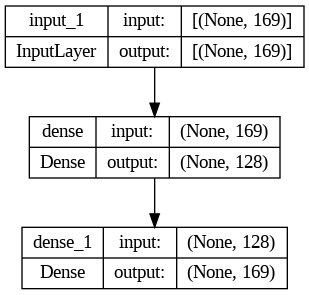

In [ ]:
# visualization of the model architecture, shapes of layer and their names
tf.keras.utils.plot_model(autoencoder, show_shapes=True, show_layer_names=True)

In [ ]:
print(encodedFeature_train.shape)
print(train_y.shape)

(84422, 128)
(84422,)


# Step 4: Building and training the ANN model

In [ ]:
#Initializing the ANN
model = Sequential()
#extracting number of input neurons from reduced feature set
input_node=encodedFeature_test.shape[1]

#adding the input layer, one hidden layer and final output layer
model = tf.keras.Sequential([
    Dense(input_node, activation='relu', input_dim=input_node),
    Dense(64, activation='relu'),
    Dense(1, activation='relu')
])
#compiling ANN model
model.compile( optimizer='adam' , loss='mean_squared_logarithmic_error', metrics = ['mse']  )

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
start = datetime.now()
model.fit(encodedFeature_train, train_y ,batch_size=32,epochs=50, callbacks=callback)
stop = datetime.now()
execution_time = stop-start
print(execution_time)

Epoch 1/50
2639/2639 [==============================] - 7s 2ms/step - loss: 0.0287 - mse: 0.4306
Epoch 2/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.0237 - mse: 0.3574
Epoch 3/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.0229 - mse: 0.3455
Epoch 4/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.0224 - mse: 0.3379
Epoch 5/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.0220 - mse: 0.3311
Epoch 6/50
2639/2639 [==============================] - 6s 2ms/step - loss: 0.0217 - mse: 0.3266
Epoch 7/50
2639/2639 [==============================] - 7s 3ms/step - loss: 0.0215 - mse: 0.3230
Epoch 8/50
2639/2639 [==============================] - 6s 2ms/step - loss: 0.0212 - mse: 0.3191
Epoch 9/50
2639/2639 [==============================] - 8s 3ms/step - loss: 0.0210 - mse: 0.3157
Epoch 10/50
2639/2639 [==============================] - 6s 2ms/step - loss: 0.0208 - mse: 0.3130
Epoch 11/50
2639/2639 [======

# Step 5: Price prediction

In [ ]:
# Predict prices
our_pred = model.predict(encodedFeature_test)

782/782 [==============================] - 1s 2ms/step


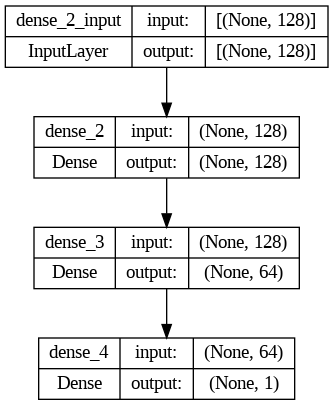

In [ ]:
# visualization of the model architecure, shapes of layer and their names
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#Execution time for the price prediction model
stop_real = datetime.now()
execution_time_real = stop_real-start_real
print(execution_time_real)

0:09:36.862791


# Step 6: Evaluation of the model and visualization

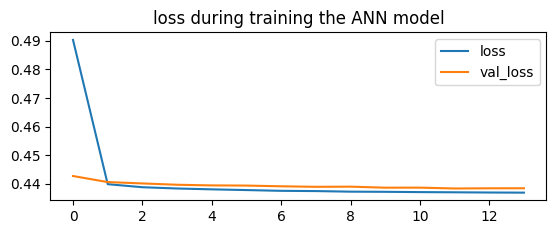

In [ ]:
# plot loss during training the ANN model
plt.subplot(211)
plt.title('loss during training the ANN model')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(encodedFeature_test, test_y)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

782/782 [==============================] - 2s 2ms/step - loss: 0.0254 - mse: 0.4069
Test Loss: 0.0254, Test Accuracy: 0.4069


In [ ]:
#Computes the mean of absolute of errors between labels and predictions.
mae=tf.keras.losses.mean_absolute_error(test_y, our_pred)
print("Mean Absolute Error (MAE):", mae.numpy())

# calculating a single scalar MAE value for better evaluation of the model
mean_mae = np.mean(mae)
print(f"Mean Absolute Error (MAE): {mean_mae:.4f}")

Mean Absolute Error (MAE): [0.6211382  0.67649704 0.6464773  ... 0.7568811  0.65529484 1.1267812 ]
Mean Absolute Error (MAE): 0.7058


In [ ]:
# Convert arrays to 1-dimensional arrays
test_y_1d = test_y.flatten()
our_pred_1d = our_pred.flatten()
df=pd.DataFrame({'Actual price':test_y_1d, 'predicted price':our_pred_1d})
df

,Actual price,predicted price
0,2.708050,3.160637
1,3.135494,3.317932
2,4.762174,3.242659
3,3.583519,2.461643
4,4.025352,3.718015
...,...,...
24995,1.945910,2.269310
24996,2.639057,2.774793
24997,2.397895,2.343085
24998,2.397895,2.543016


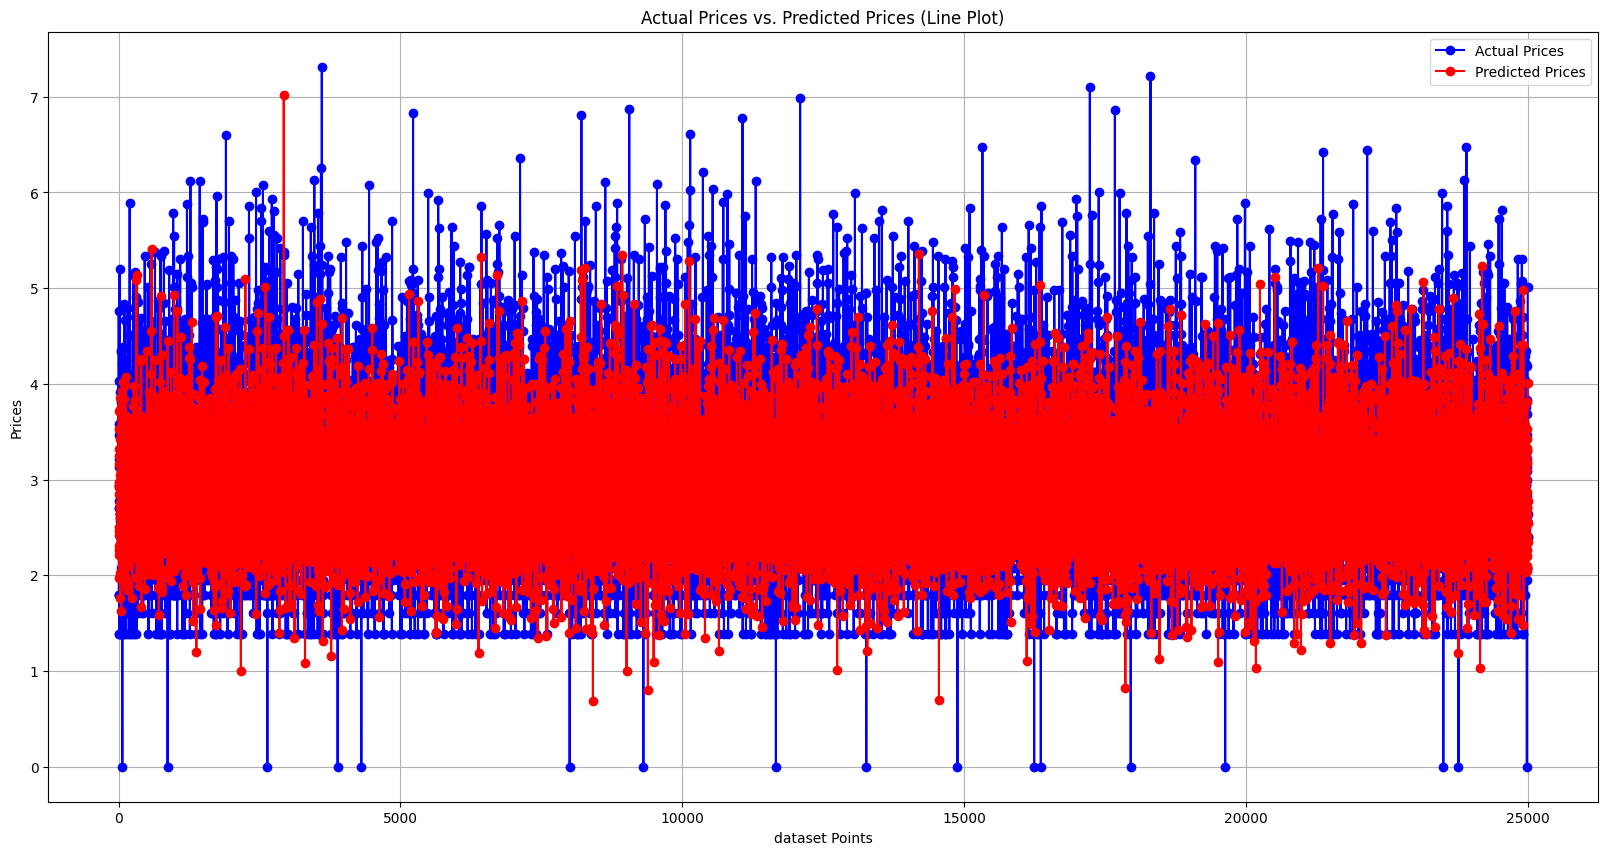

In [ ]:
# Creating a line plot representing actual vs predicted prices
plt.figure(figsize=(20, 10))
plt.plot(test_y, label='Actual Prices', marker='o', linestyle='-', color='blue')
plt.plot(our_pred, label='Predicted Prices', marker='o', linestyle='-', color='red')
plt.xlabel('dataset Points')
plt.ylabel('Prices')
plt.title('Actual Prices vs. Predicted Prices (Line Plot)')
plt.legend()
plt.grid(True)
plt.show()

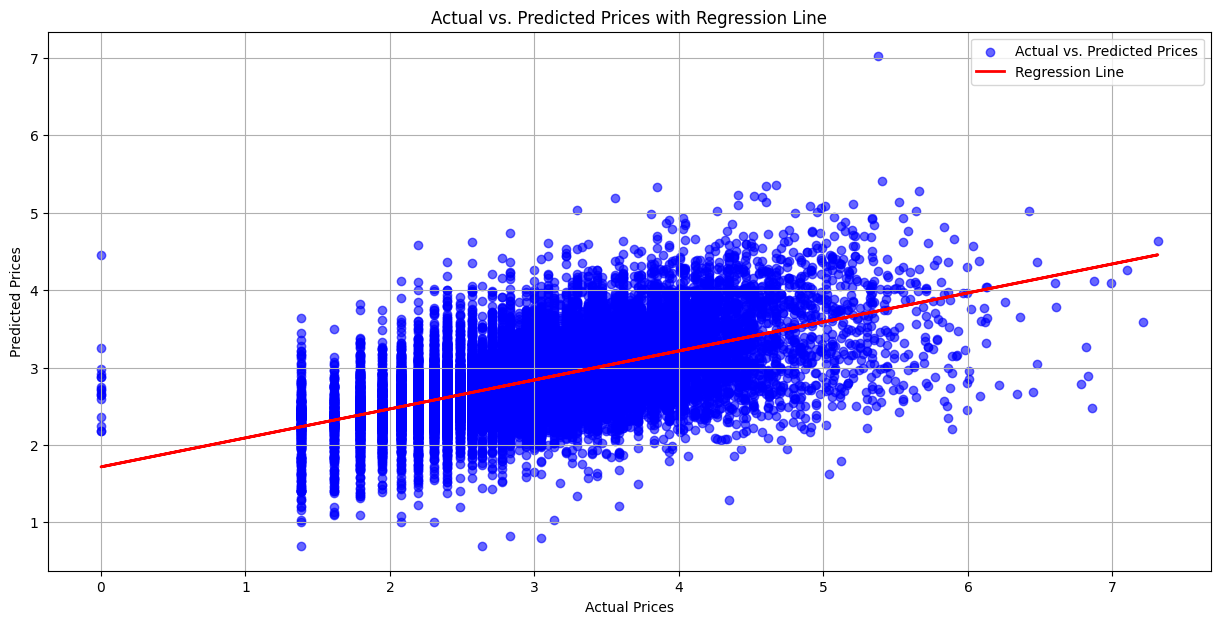

In [ ]:
# Create a scatter plot
plt.figure(figsize=(15, 7))
plt.scatter(test_y , our_pred.reshape(-1), c='blue', label='Actual vs. Predicted Prices', alpha=0.6)

# Add a regression line (best-fit line)
z = np.polyfit(test_y, our_pred.reshape(-1), 1)
p = np.poly1d(z)
plt.plot(test_y, p(test_y), c='red', label='Regression Line', linewidth=2)

# Add labels and title
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices with Regression Line')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


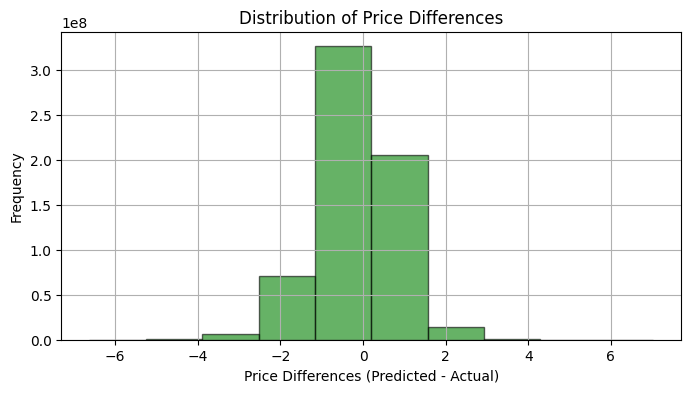

In [ ]:
# Calculate differences between actual and predicted prices
price_diff = (our_pred - test_y).flatten()
# Create a histogram of price differences with a single color
plt.figure(figsize=(8, 4))
plt.hist(price_diff, color='green', alpha=0.6, edgecolor='black')
plt.xlabel('Price Differences (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Price Differences')
plt.grid(True)
plt.show()

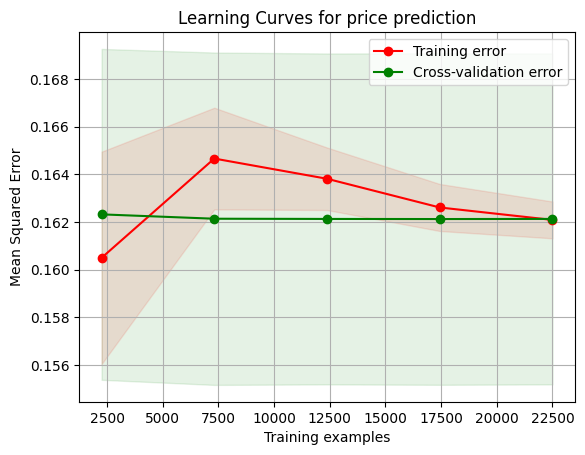

In [ ]:
# Define a function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

# Replace X and y with your actual data
X = test_y.reshape(-1, 1)  # Actual prices
y = our_pred.reshape(-1)  # Predicted prices

# Create a linear regression model
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()

title = "Learning Curves for price prediction"
cv = 10  # Number of cross-validation folds

# Plot the learning curve
plot_learning_curve(estimator, title, X, y, cv=cv)
plt.show()
